In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import warnings
import h5py
import os

In [2]:


def plot_feature_transformations(feature_array, figsize=(15, 10)):
    """
    绘制特征在多种单调变换后的分布直方图
    
    Parameters:
    -----------
    feature_array : numpy.ndarray
        输入特征数组，可能含有NaN值
    figsize : tuple, optional
        图形大小，默认为(15, 10)
    """
    # 移除NaN值
    data = feature_array[~np.isnan(feature_array)]
    if len(data) == 0:
        print("警告：输入数据全部为NaN")
        return
    
    # 计算基本统计量
    n_original = len(data)
    skew_original = stats.skew(data)
    
    # 创建图形和子图
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.ravel()
    
    # 1. 原始数据
    axes[0].hist(data, bins=50, alpha=0.7, color='blue', density=True)
    axes[0].set_title(f'Original Data\nn={n_original}, skew={skew_original:.3f}')
    axes[0].set_ylabel('Density')
    
    # 2. 对数变换 (仅适用于正数)
    if np.all(data > 0):
        log_data = np.log(data)
        skew_log = stats.skew(log_data)
        axes[1].hist(log_data, bins=50, alpha=0.7, color='green', density=True)
        axes[1].set_title(f'Log Transform\nskew={skew_log:.3f}')
    else:
        axes[1].text(0.5, 0.5, 'Skip: Data contains\nnon-positive values', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Log Transform')
    
    # 3. 平方根变换 (仅适用于非负数)
    if np.all(data >= 0):
        sqrt_data = np.sqrt(data)
        skew_sqrt = stats.skew(sqrt_data)
        axes[2].hist(sqrt_data, bins=50, alpha=0.7, color='orange', density=True)
        axes[2].set_title(f'Square Root Transform\nskew={skew_sqrt:.3f}')
    else:
        axes[2].text(0.5, 0.5, 'Skip: Data contains\nnegative values', 
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Square Root Transform')
    
    # 4. 平方变换
    square_data = np.square(data)
    skew_square = stats.skew(square_data)
    axes[3].hist(square_data, bins=50, alpha=0.7, color='red', density=True)
    axes[3].set_title(f'Square Transform\nskew={skew_square:.3f}')
    axes[3].set_ylabel('Density')
    
    # 5. Box-Cox变换 (仅适用于正数)
    if np.all(data > 0):
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                boxcox_data, _ = stats.boxcox(data)
            skew_boxcox = stats.skew(boxcox_data)
            axes[4].hist(boxcox_data, bins=50, alpha=0.7, color='purple', density=True)
            axes[4].set_title(f'Box-Cox Transform\nskew={skew_boxcox:.3f}')
        except:
            axes[4].text(0.5, 0.5, 'Box-Cox failed', 
                        ha='center', va='center', transform=axes[4].transAxes)
            axes[4].set_title('Box-Cox Transform')
    else:
        axes[4].text(0.5, 0.5, 'Skip: Data contains\nnon-positive values', 
                    ha='center', va='center', transform=axes[4].transAxes)
        axes[4].set_title('Box-Cox Transform')
    
    # 6. Yeo-Johnson变换 (适用于任意实数)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pt = PowerTransformer(method='yeo-johnson')
            yeojohnson_data = pt.fit_transform(data.reshape(-1, 1)).flatten()
        skew_yeojohnson = stats.skew(yeojohnson_data)
        axes[5].hist(yeojohnson_data, bins=50, alpha=0.7, color='brown', density=True)
        axes[5].set_title(f'Yeo-Johnson Transform\nskew={skew_yeojohnson:.3f}')
    except:
        axes[5].text(0.5, 0.5, 'Yeo-Johnson failed', 
                    ha='center', va='center', transform=axes[5].transAxes)
        axes[5].set_title('Yeo-Johnson Transform')
    
    # 7. 分位数变换到正态分布
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            qt_normal = QuantileTransformer(output_distribution='normal', random_state=42)
            quantile_normal_data = qt_normal.fit_transform(data.reshape(-1, 1)).flatten()
        skew_quantile_normal = stats.skew(quantile_normal_data)
        axes[6].hist(quantile_normal_data, bins=50, alpha=0.7, color='teal', density=True)
        axes[6].set_title(f'Quantile to Normal\nskew={skew_quantile_normal:.3f}')
        axes[6].set_ylabel('Density')
    except:
        axes[6].text(0.5, 0.5, 'Quantile transform failed', 
                    ha='center', va='center', transform=axes[6].transAxes)
        axes[6].set_title('Quantile to Normal')
    
    # 8. 分位数变换到均匀分布
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            qt_uniform = QuantileTransformer(output_distribution='uniform', random_state=42)
            quantile_uniform_data = qt_uniform.fit_transform(data.reshape(-1, 1)).flatten()
        skew_quantile_uniform = stats.skew(quantile_uniform_data)
        axes[7].hist(quantile_uniform_data, bins=50, alpha=0.7, color='olive', density=True)
        axes[7].set_title(f'Quantile to Uniform\nskew={skew_quantile_uniform:.3f}')
    except:
        axes[7].text(0.5, 0.5, 'Quantile transform failed', 
                    ha='center', va='center', transform=axes[7].transAxes)
        axes[7].set_title('Quantile to Uniform')
    
    # 9. 倒数变换 (仅适用于非零值)
    if np.all(data != 0):
        reciprocal_data = 1 / data
        skew_reciprocal = stats.skew(reciprocal_data)
        axes[8].hist(reciprocal_data, bins=50, alpha=0.7, color='coral', density=True)
        axes[8].set_title(f'Reciprocal Transform\nskew={skew_reciprocal:.3f}')
    else:
        axes[8].text(0.5, 0.5, 'Skip: Data contains\nzero values', 
                    ha='center', va='center', transform=axes[8].transAxes)
        axes[8].set_title('Reciprocal Transform')
    
    # 调整布局
    plt.tight_layout()
    plt.show()

['ACE_IMF_Bx', 'ACE_IMF_By', 'ACE_IMF_Bz']
ACE_IMF_Bx: shape=(1, 5260320), dtype=float32


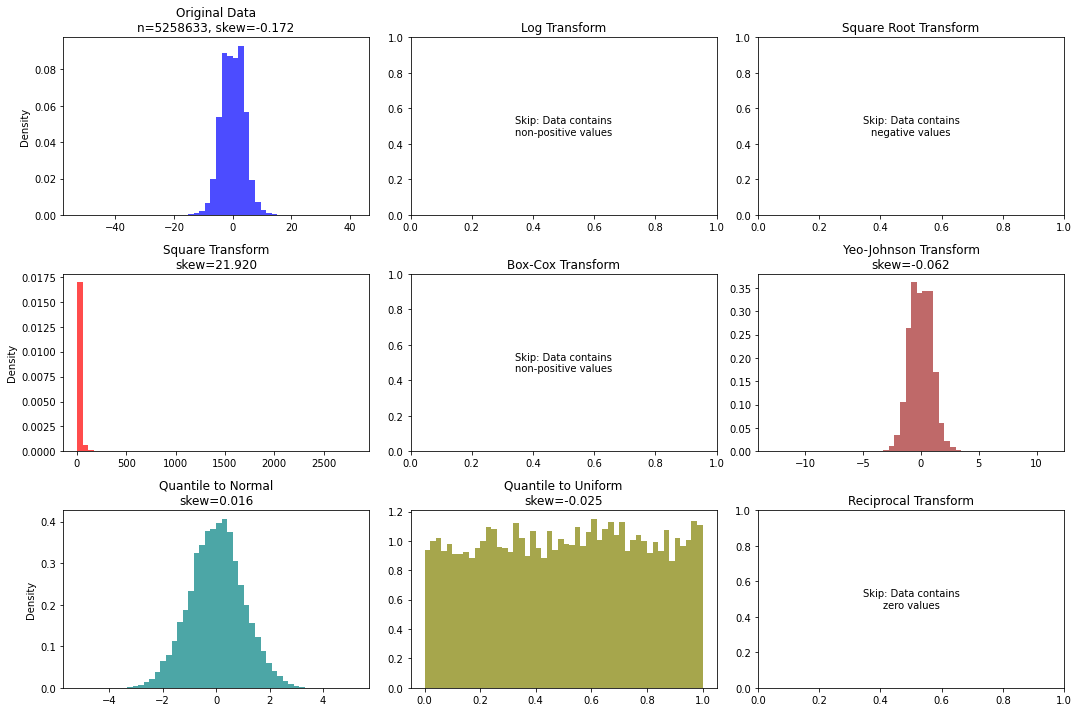

ACE_IMF_By: shape=(1, 5260320), dtype=float32


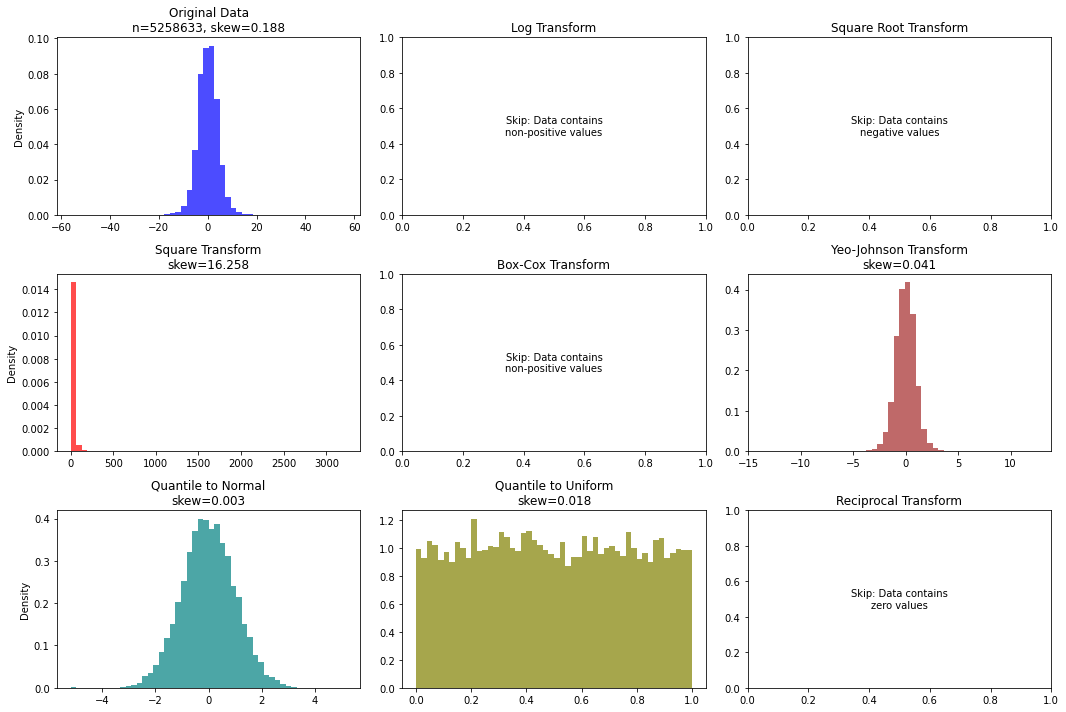

ACE_IMF_Bz: shape=(1, 5260320), dtype=float32


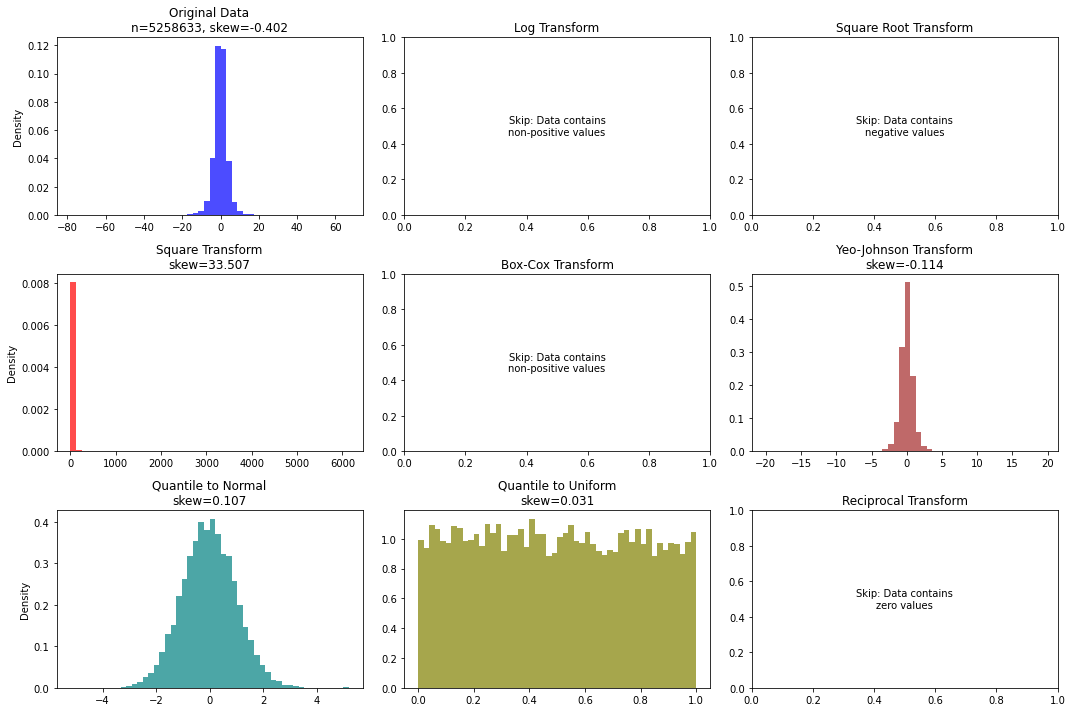

['ACE_Psw', 'ACE_Vsw']
ACE_Psw: shape=(1, 5260320), dtype=float32


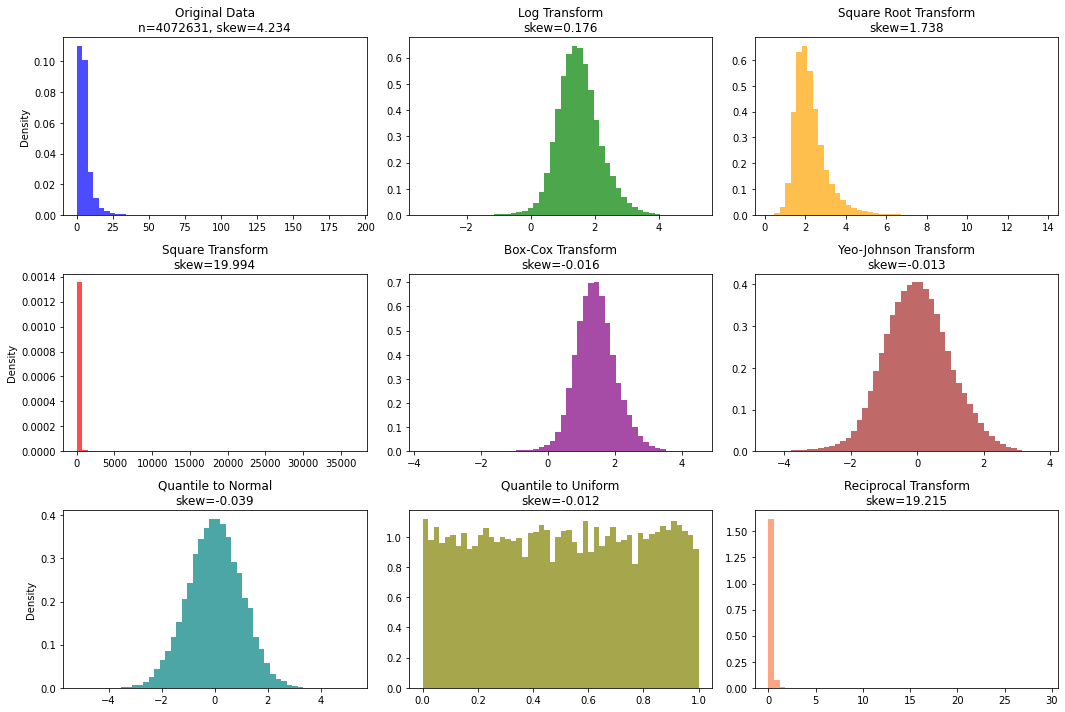

ACE_Vsw: shape=(1, 5260320), dtype=float32


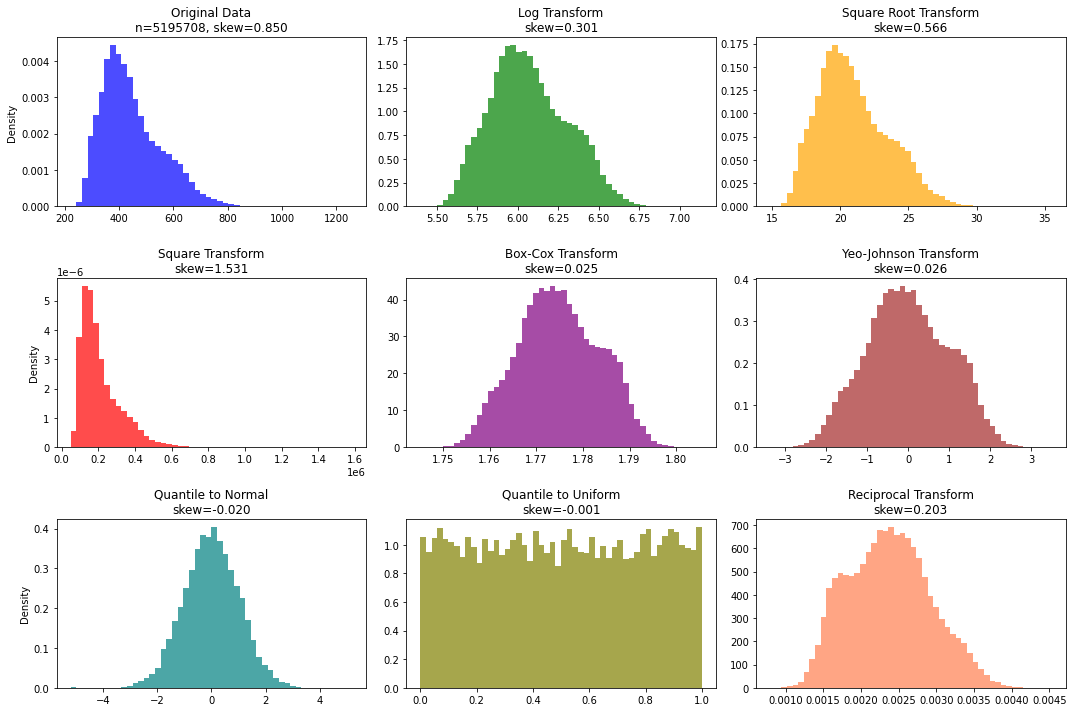

['OMNI_AE', 'OMNI_ASYMH', 'OMNI_PC', 'OMNI_SYMH']
OMNI_AE: shape=(1, 5260320), dtype=float32


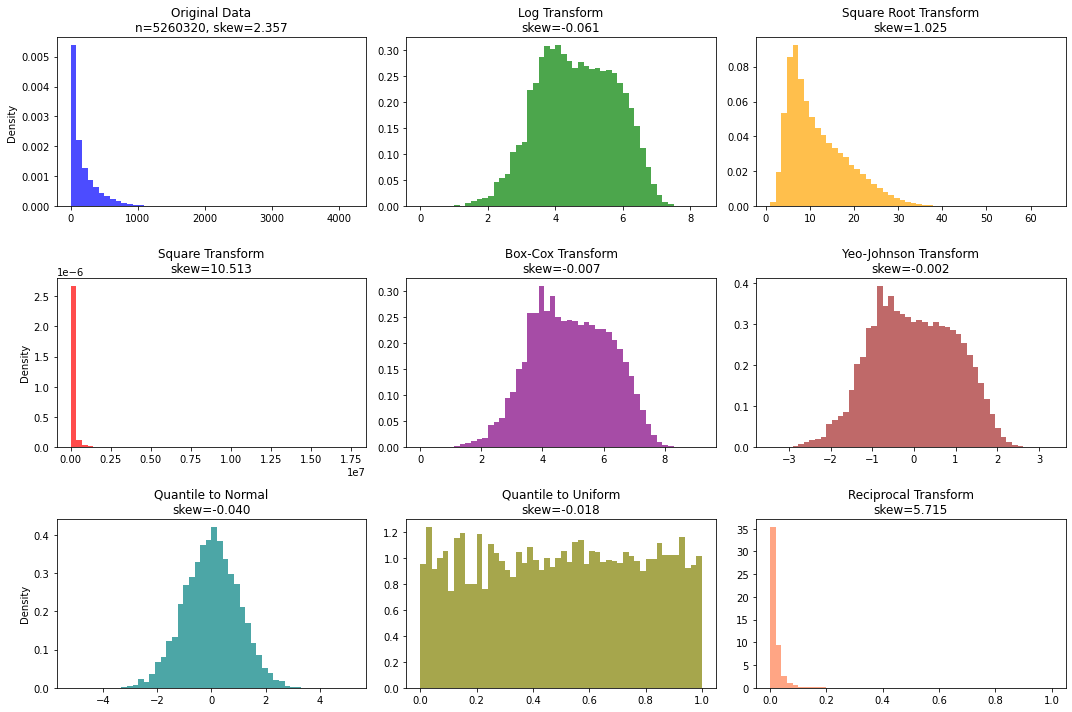

OMNI_ASYMH: shape=(1, 5260320), dtype=float32


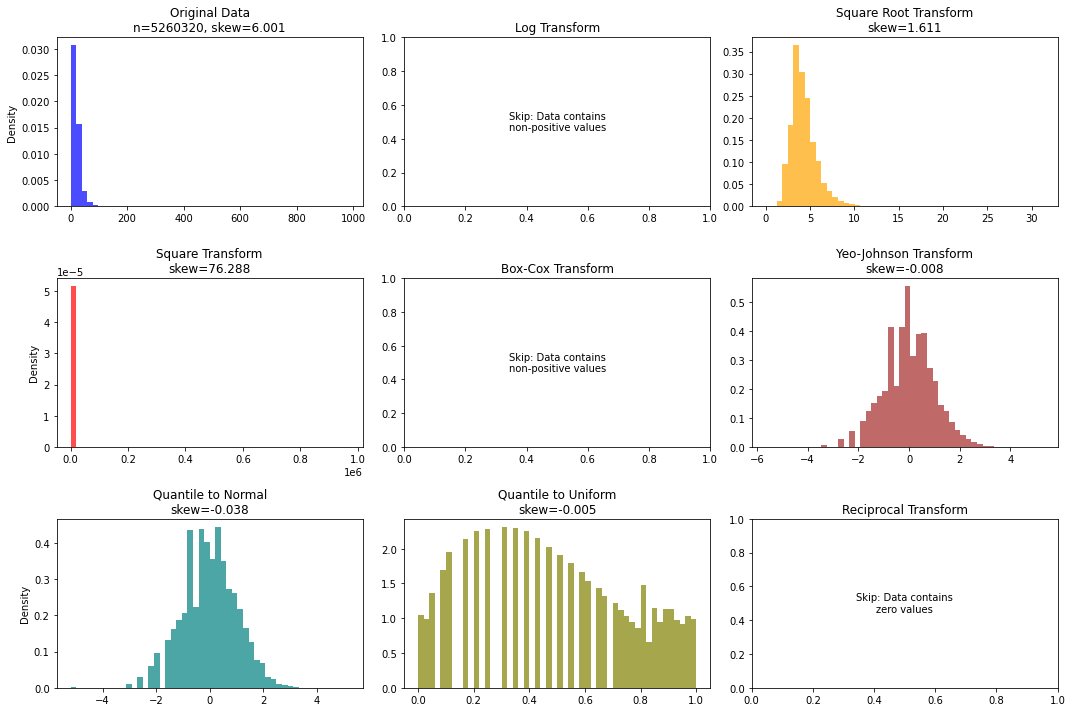

OMNI_PC: shape=(1, 5260320), dtype=float32


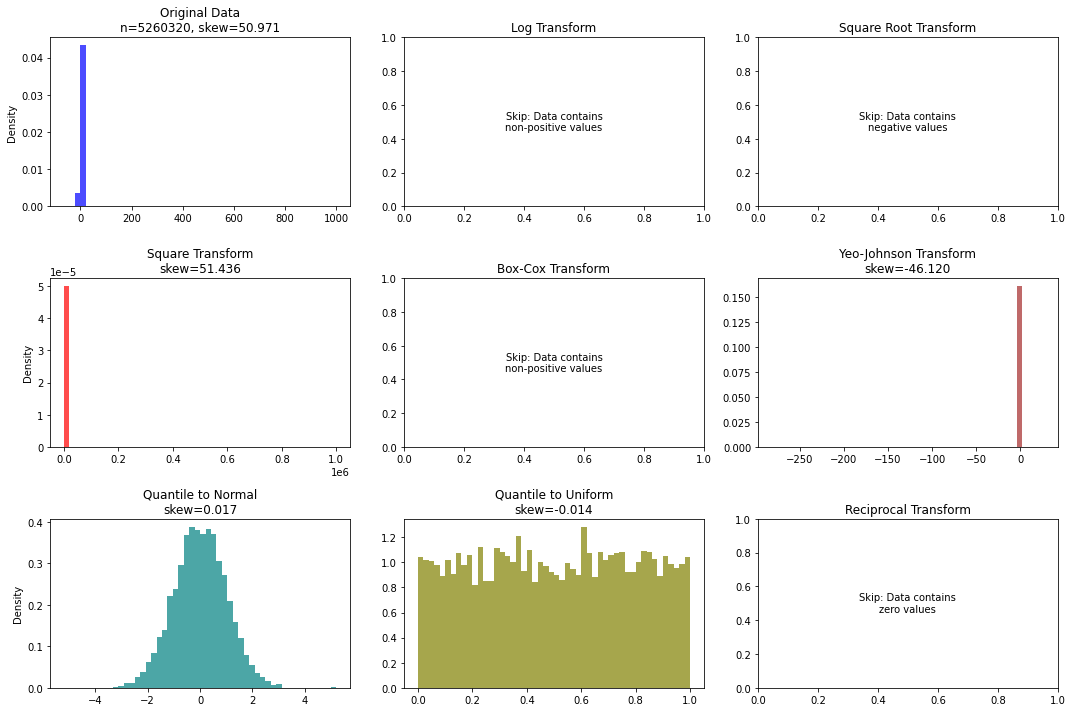

OMNI_SYMH: shape=(1, 5260320), dtype=float32


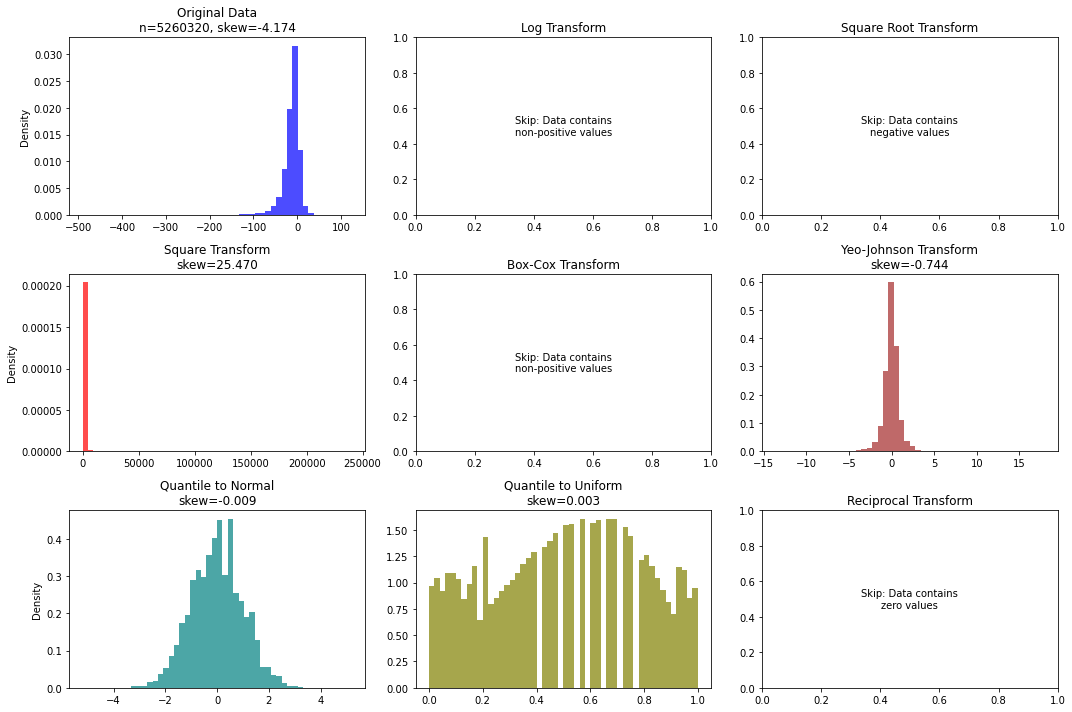

In [3]:
fpa = r"D:\hw2025\space weather\spaceWeatherLab\tmp\src\data\data"

files = os.listdir(fpa)
for fp in files:
    if "2000s" in fp:
        with h5py.File(os.path.join(fpa,fp), 'r') as f:
            # 查看文件中的所有变量
            print(list(f.keys()))
            for key in f.keys():
                data = f[key][:]
                print("="*32)
                print(f"{key}: shape={data.shape}, dtype={data.dtype}")
                plot_feature_transformations(data)